In [35]:
import numpy as np
import s3fs
import requests
import pandas as pd
import zipfile
import io
import matplotlib.pyplot as plt 


In [33]:
def print_csv_names(bucket_name, file_name):
    path_to_file = f'../data/{bucket_name}/{file_name}'
    zip_file = zipfile.ZipFile(path_to_file)
    fs = {month: {} for month in month_list}
    zip_file.printdir()
    print('\n')
    for text_file in zip_file.infolist():
        if text_file.filename.endswith('.csv'):
            print(text_file.filename)

In [34]:
print_csv_names('tripdata', '2013-citibike-tripdata.zip')

File Name                                             Modified             Size
2013-citibike-tripdata/                        2024-02-22 00:06:56            0
2013-citibike-tripdata/4_April/                2024-02-14 10:09:16            0
2013-citibike-tripdata/12_December/            2024-02-22 00:03:04            0
2013-citibike-tripdata/.DS_Store               2024-02-22 00:07:16        12292
__MACOSX/2013-citibike-tripdata/._.DS_Store    2024-02-22 00:07:16          120
2013-citibike-tripdata/201309-citibike-tripdata.csv 2014-03-27 23:40:34    201965642
__MACOSX/2013-citibike-tripdata/._201309-citibike-tripdata.csv 2014-03-27 23:40:34          276
2013-citibike-tripdata/11_November/            2024-02-22 00:03:00            0
2013-citibike-tripdata/7_July/                 2024-02-22 00:02:38            0
2013-citibike-tripdata/201311-citibike-tripdata.csv 2014-03-27 23:43:44    131891356
__MACOSX/2013-citibike-tripdata/._201311-citibike-tripdata.csv 2014-03-27 23:43:44          27

In [48]:
def get_test_data():
    with zipfile.ZipFile('../data/tripdata/2013-citibike-tripdata.zip', 'r') as zip_file:
        month_df = pd.read_csv(zip_file.open('2013-citibike-tripdata/6_June/201306-citibike-tripdata_1.csv'), encoding='latin-1')
    return month_df

In [49]:
test_df = get_test_data()

In [57]:
test_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1


In [56]:
test_df.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                    float64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
dtype: object

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                    float64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
dtype: object

# I only extract the monthly csv data, e.g. 
### 2013-citibike-tripdata/10_October/201310-citibike-tripdata_1.csv and 
### 2013-citibike-tripdata/10_October/201310-citibike-tripdata_2.csv
### for October

In [82]:
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Input: path or buffer
# Output: dict with month as key and list of pandas dataframes as values
def process_zip_file(input_data) -> dict:
    # Construct output dictionary
    fs = {month: [] for month in month_list}
    with zipfile.ZipFile(input_data, 'r') as zip_file:
        for text_file in zip_file.infolist():
            cur_filename = text_file.filename
            if cur_filename.endswith('.csv') and not cur_filename.startswith('__MACOSX'):
                dir_names = text_file.filename.split('/')
                
                if len(dir_names) == 3:
                        year = dir_names[0].split('-')[0]
                        month = dir_names[1].split('_')[1]
                        if month in month_list:
                            print(f'Processing {year} {month}: {dir_names[2]}')
                            # encoding utf-8 results in UnicodeDecodeError, see:
                            # https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte
                            month_df = pd.read_csv(zip_file.open(text_file.filename), encoding='latin-1')
                            month_df['starttime'] = pd.to_datetime(month_df['starttime'])
                            month_df['stoptime'] = pd.to_datetime(month_df['stoptime'])
                            # Per month there can be one or two CSV files
                            fs[month].append(month_df)
                            
    total_rows = 0
    # Concatenate CSV files per month
    for month in fs:
        # Skip empty lists
        if len(fs[month]) > 0:
            fs[month] = pd.concat(fs[month])
            cur_rows = len(fs[month].index)
            print(f'{month} no. of rows: {cur_rows}')
            total_rows += cur_rows
        else:
            fs[month] = None
            print(f'{month} no. of rows: 0')
    print(f'Total no. of rows: {total_rows}')
    return fs

# Creates zipfile.Zipfile from csv.zip saved on local disk
# Tries to get csv from ../data/BUCKET_NAME/FILE_NAME.zip
def load_zip_csv_offline(bucket_name: str, file_name: str) -> dict:
    path_to_file = f'../data/{bucket_name}/{file_name}.zip'
    
    return process_zip_file(path_to_file)


# Creates zipfile.Zipfile from public access s3 URL
def load_zip_csv_url(bucket_name: str, file_name: str) -> dict:
    response = requests.get(f'https://s3.amazonaws.com/{bucket_name}/{file_name}.zip')
    if response.status_code == 200:
        print("Successfully downloaded the zip file.")
        # Load the zip file into memory
        buffer = io.BytesIO(response.content)
        
        return process_zip_file(buffer)
    else:
        print(f'Http get request Error {response.status_code}')
        

def load_zip_csv(bucket_name: str, file_name: str):
    try:
        print('Trying to load file from disk.')
        data = load_zip_csv_offline(bucket_name, file_name)
        print('Loaded file from disk.')

    except FileNotFoundError:
        print('Could not load from disk, loading from URL.')
        data = load_zip_csv_url(bucket_name, file_name)
        print('Loaded file from URL.')
        
    except:
        raise FileNotFoundError("Could not load file from disk or URL.")
        
    finally:
        return data


In [83]:
data_2013 = load_zip_csv('tripdata', '2013-citibike-tripdata')

Trying to load file from disk.
Processing 2013 December: 201312-citibike-tripdata_1.csv
Processing 2013 November: 201311-citibike-tripdata_1.csv
Processing 2013 July: 201307-citibike-tripdata_1.csv
Processing 2013 October: 201310-citibike-tripdata_2.csv
Processing 2013 October: 201310-citibike-tripdata_1.csv
Processing 2013 September: 201309-citibike-tripdata_2.csv
Processing 2013 September: 201309-citibike-tripdata_1.csv
Processing 2013 August: 201308-citibike-tripdata_1.csv
Processing 2013 August: 201308-citibike-tripdata_2.csv
Processing 2013 June: 201306-citibike-tripdata_1.csv
January no. of rows: 0
February no. of rows: 0
March no. of rows: 0
April no. of rows: 0
May no. of rows: 0
June no. of rows: 577703
July no. of rows: 843416
August no. of rows: 1001958
September no. of rows: 1034359
October no. of rows: 1037712
November no. of rows: 675774
December no. of rows: 443966
Total no. of rows: 5614888
Loaded file from disk.


In [112]:
data_2014 = load_zip_csv('tripdata', '2014-citibike-tripdata')

Trying to load file from disk.
Processing 2014 April: 201404-citibike-tripdata_1.csv
Processing 2014 December: 201412-citibike-tripdata_1.csv
Processing 2014 November: 201411-citibike-tripdata_1.csv
Processing 2014 July: 201407-citibike-tripdata_1.csv
Processing 2014 October: 201410-citibike-tripdata_1.csv
Processing 2014 September: 201409-citibike-tripdata_1.csv
Processing 2014 August: 201408-citibike-tripdata_1.csv
Processing 2014 June: 201406-citibike-tripdata_1.csv
Processing 2014 March: 201403-citibike-tripdata_1.csv
Processing 2014 January: 201401-citibike-tripdata_1.csv
Processing 2014 February: 201402-citibike-tripdata_1.csv
Processing 2014 May: 201405-citibike-tripdata_1.csv
January no. of rows: 300400
February no. of rows: 224736
March no. of rows: 439117
April no. of rows: 670780
May no. of rows: 866117
June no. of rows: 936880
July no. of rows: 968842
August no. of rows: 963489
September no. of rows: 953887
October no. of rows: 828711
November no. of rows: 529188
December n

In [90]:
def plot_tripcount_monthly(year: str, year_dict: dict):
    month_list_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dez']
    month_counts = []
    for month in month_list:
        month_df = year_dict[month]
        if month_df is not None:
            month_counts.append(len(month_df.index))
        else:
            month_counts.append(0)
        
    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(month_list_short, month_counts)
    
    plt.xlabel("month")
    plt.ylabel("No. of trips")
    plt.title(f"Citibike Total Trips per Month in {year}")
    plt.show()

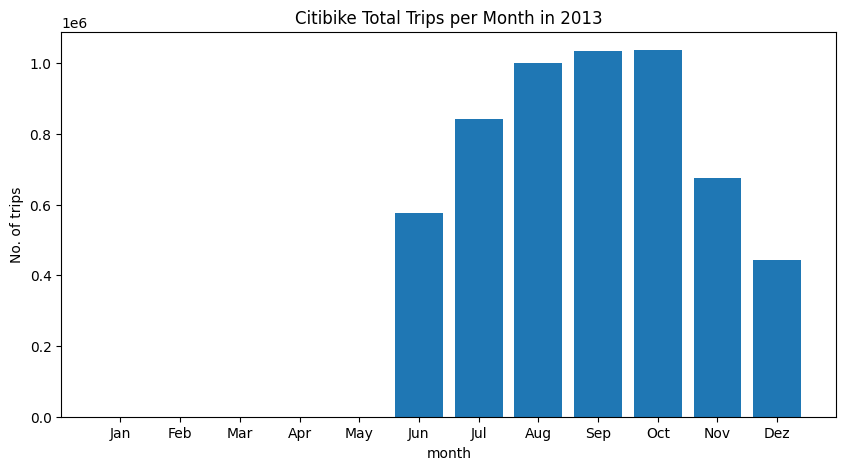

In [85]:
plot_tripcount_monthly('2013', data_2013)

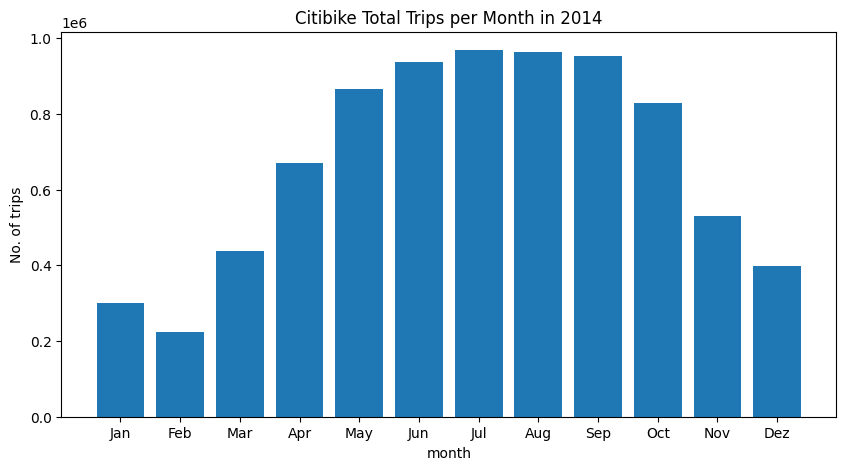

In [43]:
plot_tripcount_monthly('2014', data_2014)

In [110]:
# If month is not specified, plot over whole year
def plot_triphour(year: str, year_dict: dict,  month: str = ''):
    if month != '':
        df = year_dict[month]
    df_count = df["starttime"].groupby(df["starttime"].dt.hour).count()
    df_count.plot(kind="bar",  figsize=(10, 5), ylabel='count')

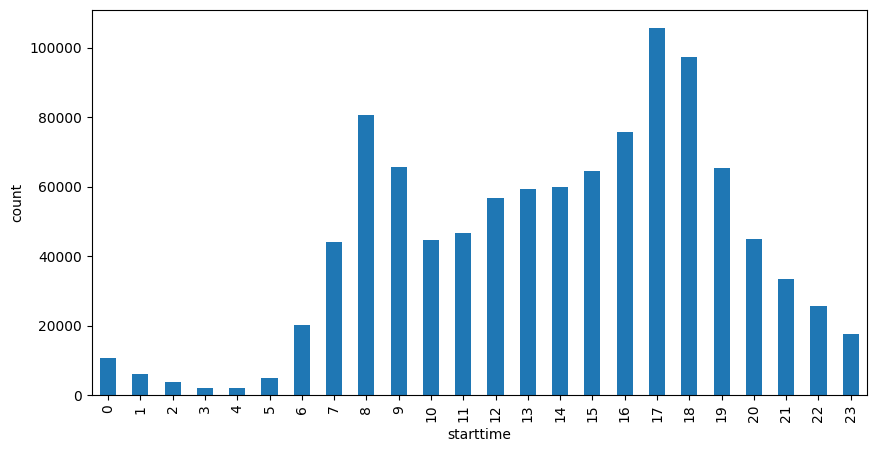

In [111]:
plot_triphour_month('2013', 'October', data_2013)

In [ ]:
plot_triphour_month('2014', 'October', data_2014)

In [44]:
print(data_2013['October'][1].head())

   tripduration            starttime             stoptime  start station id  \
0           326  2013-10-01 00:01:08  2013-10-01 00:06:34               239   
1           729  2013-10-01 00:01:21  2013-10-01 00:13:30               322   
2           520  2013-10-01 00:01:24  2013-10-01 00:10:04               174   
3           281  2013-10-01 00:01:25  2013-10-01 00:06:06               430   
4           196  2013-10-01 00:01:27  2013-10-01 00:04:43               403   

         start station name  start station latitude  start station longitude  \
0  Willoughby St & Fleet St               40.691966               -73.981302   
1   Clinton St & Tillary St               40.696192               -73.991218   
2           E 25 St & 1 Ave               40.738177               -73.977387   
3          York St & Jay St               40.701485               -73.986569   
4            E 2 St & 2 Ave               40.725029               -73.990697   

   end station id             end station na

In [10]:
print(data['October'][1].head())

   tripduration            starttime             stoptime  start station id  \
0           326  2013-10-01 00:01:08  2013-10-01 00:06:34               239   
1           729  2013-10-01 00:01:21  2013-10-01 00:13:30               322   
2           520  2013-10-01 00:01:24  2013-10-01 00:10:04               174   
3           281  2013-10-01 00:01:25  2013-10-01 00:06:06               430   
4           196  2013-10-01 00:01:27  2013-10-01 00:04:43               403   

         start station name  start station latitude  start station longitude  \
0  Willoughby St & Fleet St               40.691966               -73.981302   
1   Clinton St & Tillary St               40.696192               -73.991218   
2           E 25 St & 1 Ave               40.738177               -73.977387   
3          York St & Jay St               40.701485               -73.986569   
4            E 2 St & 2 Ave               40.725029               -73.990697   

   end station id             end station na

In [18]:
print(data_from_s3['October'][1].head())

   tripduration            starttime             stoptime  start station id  \
0           326  2013-10-01 00:01:08  2013-10-01 00:06:34               239   
1           729  2013-10-01 00:01:21  2013-10-01 00:13:30               322   
2           520  2013-10-01 00:01:24  2013-10-01 00:10:04               174   
3           281  2013-10-01 00:01:25  2013-10-01 00:06:06               430   
4           196  2013-10-01 00:01:27  2013-10-01 00:04:43               403   

         start station name  start station latitude  start station longitude  \
0  Willoughby St & Fleet St               40.691966               -73.981302   
1   Clinton St & Tillary St               40.696192               -73.991218   
2           E 25 St & 1 Ave               40.738177               -73.977387   
3          York St & Jay St               40.701485               -73.986569   
4            E 2 St & 2 Ave               40.725029               -73.990697   

   end station id             end station na

In [44]:
#citibike_data_path = './data/citibike/'
#path_to_file = '2013-citibike-tripdata.zip'
#"C:\Users\Joris\Projects\coding-challenge-AXA\data\tripdata\2013-citibike-tripdata.zip"
load_zip_csv_offline('tripdata', '2013-citibike-tripdata.zip')
load_zip_csv_url('tripdata', '2013-citibike-tripdata.zip')

2013-citibike-tripdata/201309-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201309-citibike-tripdata.csv
2013-citibike-tripdata/201311-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201311-citibike-tripdata.csv
2013-citibike-tripdata/201307-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201307-citibike-tripdata.csv
2013-citibike-tripdata/201308-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201308-citibike-tripdata.csv
2013-citibike-tripdata/201306-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201306-citibike-tripdata.csv
2013-citibike-tripdata/201310-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201310-citibike-tripdata.csv
2013-citibike-tripdata/201312-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201312-citibike-tripdata.csv
2013-citibike-tripdata/12_December/201312-citibike-tripdata_1.csv
2013-citibike-tripdata/11_November/201311-citibike-tripdata_1.csv
2013-citibike-tripdata/7_July/201307-citibike-tripdata_1.csv
20

In [47]:
for i in range(0, 12):
    load_zip_csv_offline('tripdata', f'{2013 + i}-citibike-tripdata.zip')

2013-citibike-tripdata/201309-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201309-citibike-tripdata.csv
2013-citibike-tripdata/201311-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201311-citibike-tripdata.csv
2013-citibike-tripdata/201307-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201307-citibike-tripdata.csv
2013-citibike-tripdata/201308-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201308-citibike-tripdata.csv
2013-citibike-tripdata/201306-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201306-citibike-tripdata.csv
2013-citibike-tripdata/201310-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201310-citibike-tripdata.csv
2013-citibike-tripdata/201312-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201312-citibike-tripdata.csv
2013-citibike-tripdata/12_December/201312-citibike-tripdata_1.csv
2013-citibike-tripdata/11_November/201311-citibike-tripdata_1.csv
2013-citibike-tripdata/7_July/201307-citibike-tripdata_1.csv
20

FileNotFoundError: [Errno 2] No such file or directory: '../data/tripdata/2024-citibike-tripdata.zip'